(201, 150)
(201, 75) (201, 75)


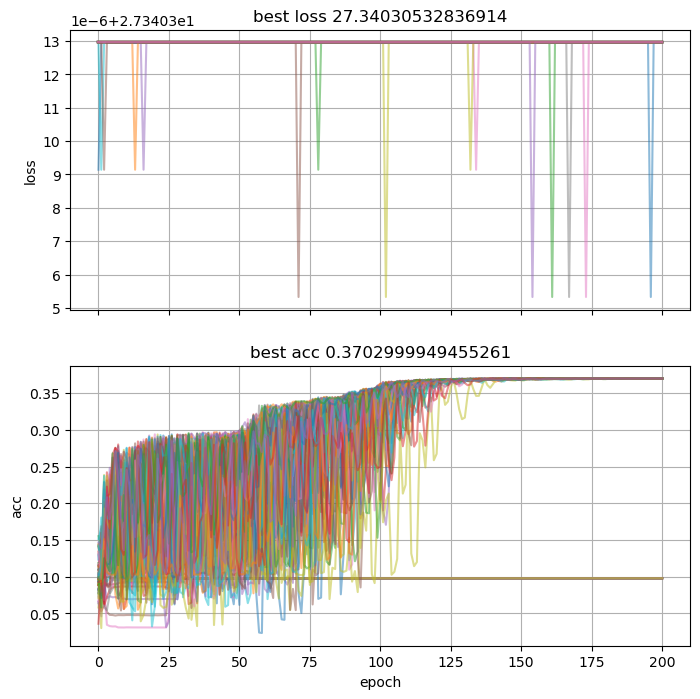

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

data = pd.read_csv("./result/mnist/06-25-01-20_75_200_0.35_0.8_0.7_acc.csv", header=None)
print(data.shape)

loss = pd.DataFrame()
acc = pd.DataFrame()

for i in range(len(data.iloc[0])):
    if i % 2 == 0:
        loss[i] = data[i]
        # loss.append(iris[i])
    else:
        acc[i] = data[i]
        # acc.append(iris[i])

print(loss.shape, acc.shape)
# print(loss)

fig, axes = plt.subplots(nrows=2, sharey=False, sharex=True, figsize=(8,8))

loss.replace('nan' ,np.inf ,inplace=True)
loss = loss.fillna(np.inf)

loss.plot(kind="line", ax=axes[0], legend=False, alpha=0.5, ylabel="loss", grid=True, title=f"best loss {loss.min(numeric_only=True).min()}")

acc.plot(kind="line", ax=axes[1], legend=False, alpha=0.5, ylabel="acc", xlabel="epoch", grid=True, title=f"best acc {acc.max(numeric_only=True).max()}")

plt.show()
plt.clf()
plt.clf()
plt.close()
plt.close()

In [11]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

In [29]:
def make_model():
    model = Sequential()
    model.add(
        Conv2D(32, kernel_size=(5, 5), activation="relu", input_shape=(28, 28, 1))
    )
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    # model.summary()

    return model


model = make_model()
weights = model.get_weights()

print(model.summary())

for i in range(len(weights)):
    print(weights[i].shape)
    print(weights[i].min(), weights[i].max())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 3, 3, 64)          0         
                                                                 
 flatten_26 (Flatten)        (None, 576)             

In [2]:
model = make_model()
# json_ = model.to_json()
# print(json_)
# for layer in model.get_weights():
# print(layer.shape)
weight = model.get_weights()

2023-05-26 03:53:33.924839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 03:53:33.928891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 03:53:33.929032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 03:53:33.929450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
from time import time

import cupy as cp


def encode(weights):
    w_gpu = cp.array([])
    lenght = []
    shape = []
    for layer in weights:
        shape.append(layer.shape)
        w_ = layer.reshape(-1)
        lenght.append(len(w_))
        w_gpu = cp.append(w_gpu, w_)

    return w_gpu, shape, lenght


def decode(weight, shape, lenght):
    weights = []
    start = 0
    for i in range(len(shape)):
        end = start + lenght[i]
        print(f"{start} ~ {end}")
        print(f"{shape[i]}")
        w_ = weight[start:end]
        w_ = w_.reshape(shape[i])
        weights.append(w_)
        start = end

    return weights


w = 0.8
v, _, _ = encode(weight)
c0 = 0.5
c1 = 1.5
r0 = 0.2
r1 = 0.8
p_best, _, _ = encode(weight)
g_best, _, _ = encode(weight)
layer, shape, leng = encode(weight)

# new_v = w*v[i]
# new_v = new_v + c0*r0*(p_best[i] - layer)
# new_v = new_v + c1*r1*(self.g_best[i] - layer)

start = time()
new_velocity = w * v + c0 * r0 * (p_best - layer) + c1 * r1 * (g_best - layer)

# print(new_velocity)

we2 = decode(new_velocity, shape, leng)
# print(we2)


# # s= [1,2]
# print(w)
print(leng)
print(shape)

# w2 = w
# c1 = c

# tf_start = time()
# w3 = tf.multiply(w2, w)
# tf_end = time()
# mul_start = time()
# w4 = w2 * w
# mul_end = time()
# cuda_start = time()
# w5 = c1 * c
# cuda_end = time()

# print(f"tf 연산 > {tf_end-tf_start} | {w3}")
# print(f"곱셈 연산 > {mul_end-mul_start} | {w4}")
# print(f"cuda 연산 > {cuda_end-cuda_start} | {w5}")

# for i in range(len(w)):
#     if w[i] != w2[i]:
#         print("not same")
#         break
#     else:
#         print("same")

0 ~ 800
(5, 5, 1, 32)
800 ~ 832
(32,)
832 ~ 19264
(3, 3, 32, 64)
19264 ~ 19328
(64,)
19328 ~ 93056
(576, 128)
93056 ~ 93184
(128,)
93184 ~ 94464
(128, 10)
94464 ~ 94474
(10,)
[800, 32, 18432, 64, 73728, 128, 1280, 10]
[(5, 5, 1, 32), (32,), (3, 3, 32, 64), (64,), (576, 128), (128,), (128, 10), (10,)]


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def get_xor():
    x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([[0], [1], [1], [0]])

    return x, y


def get_iris():
    iris = load_iris()
    x = iris.data
    y = iris.target

    y = keras.utils.to_categorical(y, 3)

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, shuffle=True, stratify=y
    )

    return x_train, x_test, y_train, y_test


# model = keras.models.load_model("./result/xor/06-02-13-31/75_0.35_0.8_0.6.h5")
model = keras.models.load_model("./result/iris/06-02-13-48/50_0.4_0.8_0.7.h5")
# x,y = get_xor()
x_train, x_test, y_train, y_test = get_iris()

print(model.predict(x_test))
print(y_test)
print(model.evaluate(x_test, y_test))

1/1 [==============================] - 0s 452ms/step
[[0.0000000e+00 1.0000000e+00 8.5117706e-28]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.3700031e-35 0.0000000e+00]
 [1.0000000e+00 1.3158974e-19 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.4602315e-27 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 2.4845295e-16 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.6942224e-33]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 9.0455008e-36 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.8117375e-33 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 6.7984806e-36]
 [0.0000000e+00 1.7472901e-25 1.0000000e+00]
 [0.0000000e+00 6.2991115e-37 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0598510e-30 1.0000000e+00]
 [1.0000000e+00 1.7519910e-30 0.0000000e+00]
 [

2023-06-02 14:34:49.851147: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
import tensorflow.compiler as tf_cc
import tensorrt as trt

linked_trt_ver = tf_cc.tf2tensorrt._pywrap_py_utils.get_linked_tensorrt_version()
print(f"Linked TRT ver: {linked_trt_ver}")

2023-06-11 14:01:31.378413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0
Linked TRT ver: (8, 4, 3)
